In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import networkx as nx
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.python.ops import gen_array_ops

In [2]:
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
DATASET_PATH = f'../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

def load_data():
    featuresNumber = (NUMBER_NODES * NUMBER_NODES - NUMBER_NODES) // 2 

    def get_tuple_dataset(row):
        X = row[0 : featuresNumber].astype('float32')
        Y = row[featuresNumber: ].astype('float32') # opt_band is in target
        return X, Y

    df = pd.read_csv(DATASET_PATH)
    train_dataset_df = df.sample(frac=0.8)
    df_remaining = df.drop(index=train_dataset_df.index)
    val_dataset_df = df_remaining.sample(frac=0.7)
    test_dataset_df = df_remaining.drop(index=val_dataset_df.index)

    train_dataset = list(map(get_tuple_dataset, train_dataset_df.to_numpy()))
    val_dataset = list(map(get_tuple_dataset, val_dataset_df.to_numpy()))
    test_dataset = list(map(get_tuple_dataset, test_dataset_df.to_numpy()))
    return train_dataset, val_dataset, test_dataset

In [3]:
train_dataset, val_dataset, test_dataset = load_data()

In [4]:
def getData_2(dataset):
    train = []
    train_nodelist = []
    for graphInput, target in dataset:
        graphNodeList = target[1 : ]
        train.append(graphInput)
        train_nodelist.append(graphNodeList)
    return np.array(train), np.array(train_nodelist)

In [5]:
train, train_nodelist = getData_2(train_dataset)
val, val_nodelist= getData_2(val_dataset)
test, test_nodelist = getData_2(test_dataset)

print(train.shape)
print(train_nodelist.shape)

(835, 21)
(835, 7)


In [6]:
cross = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
loss_object = tf.keras.losses.MeanSquaredError()

def loss_repeated_labels(roundedOutput, roundedTrue):
  true_used, true_indexes = tf.unique(tf.squeeze(roundedTrue))
  used_labels, indexes, counts = tf.unique_with_counts(tf.squeeze(roundedOutput))
  counts = tf.cast(counts, tf.float32)
  # 1 - counts = quao longe os elementos de counts estão de repetir uma vez só (elemento unico)
  squaredDiff = cross(tf.ones_like(counts), counts)
  mseIndexes = cross(tf.cast(true_indexes, tf.float32), tf.cast(indexes, tf.float32))
  # o quao longe os indexes estao de ser 0,1,2,3,4,5,6
  loss = tf.math.reduce_variance(counts) + squaredDiff + mseIndexes
  return loss

def customLoss(true, pred):
  c = loss_object(true, pred)
  roundedOutput = tf.round(pred)
  roundedTrue = tf.round(true)
  loss_repeated = loss_repeated_labels(roundedOutput, roundedTrue)
  return c + loss_repeated


In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train))
print(normalizer.mean.numpy())

first = np.array(train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

model = tf.keras.models.Sequential([
  # normalizer,
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(NUMBER_NODES)
])

model.compile(optimizer='adam',
              loss=customLoss,
              metrics=['accuracy'])

history = model.fit(
    train, train_nodelist,
    validation_data=(val, val_nodelist),
    epochs=180,
    batch_size=1
)

[[0.         0.11736526 0.5928144  0.7341317  0.79401183 0.869461
  0.00718563 0.25029936 0.675449   0.788024   0.8479041  0.0251497
  0.41676638 0.6826346  0.7532934  0.14491016 0.497006   0.7233532
  0.27664673 0.7293411  0.560479  ]]
First example: [[0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.]]

Normalized: [[ 0.    2.74 -1.21  0.6   0.51  0.39 -0.09  1.73  0.69  0.52  0.42 -0.16
   1.18  0.68  0.57 -0.41  1.01  0.62 -0.62  0.61 -1.13]]
Epoch 1/180
835/835 [==============================] - 7s 6ms/step - loss: nan - accuracy: 0.3305 - val_loss: 195.4877 - val_accuracy: 0.4452
Epoch 2/180
835/835 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.3234 - val_loss: nan - val_accuracy: 0.1644
Epoch 3/180
835/835 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.3281 - val_loss: 137.8035 - val_accuracy: 0.3082
Epoch 4/180
835/835 [==============================] - 4s 5ms/step - loss: nan - accuracy: 0.3425 - val_loss: nan -

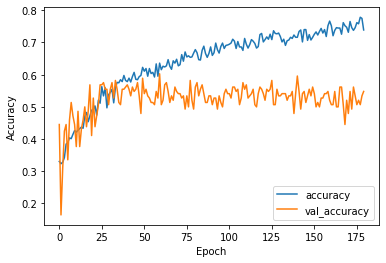

In [8]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

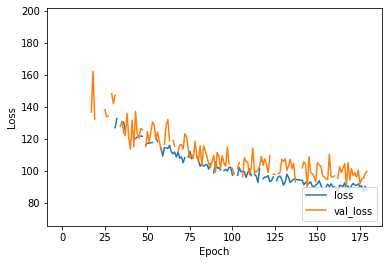

In [9]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [10]:
# test = np.array([test_images[0]])
pred = model.predict(test)
true = test_nodelist
# print(pred)
print("Pred")
print((pred).round())
print("True")
print(true)

Pred
[[ 1.  6.  5.  0.  3.  3.  5.]
 [ 2.  3.  5.  2.  5.  3.  3.]
 [ 2.  4.  3.  1.  5.  3.  3.]
 [ 3.  6.  4.  0.  2.  5.  1.]
 [ 3.  4.  3.  0.  4.  5.  3.]
 [ 2. -0.  6.  4.  5.  2.  2.]
 [ 2.  3.  4.  3.  4.  1.  3.]
 [ 3.  3.  2.  3.  6.  1.  3.]
 [ 2.  4.  6.  0.  5.  1.  3.]
 [ 2.  0.  6.  5.  4.  2.  2.]
 [ 2.  1.  4.  6.  4.  1.  3.]
 [ 2.  2.  5.  4.  5.  0.  3.]
 [ 1.  1.  4.  6.  4.  1.  3.]
 [ 2.  2.  5.  6.  1.  2.  3.]
 [ 2.  1.  5.  6.  4.  1.  3.]
 [ 1. -0.  6.  4.  5.  3.  2.]
 [ 2.  1.  4.  5.  5.  1.  2.]
 [ 1. -0.  6.  4.  5.  3.  2.]
 [ 4.  2.  4.  2.  5.  1.  3.]
 [ 1.  4.  5.  5.  1.  1.  3.]
 [ 1.  4.  6.  1.  1.  5.  2.]
 [ 2.  3.  2.  6.  5. -0.  3.]
 [ 2.  3.  4.  6.  1.  1.  3.]
 [ 3.  3.  2.  5.  5.  0.  3.]
 [ 2.  1.  5.  5.  5.  1.  1.]
 [ 2.  3.  4.  4.  3.  2.  3.]
 [ 3.  4.  2.  4.  3.  4.  1.]
 [ 3.  2.  2.  6.  5.  2.  2.]
 [ 2.  2.  5.  5.  2.  1.  3.]
 [ 4.  6.  2. -0.  3.  5.  2.]
 [ 3.  3.  3.  5.  4.  2.  1.]
 [ 3.  4.  2.  5.  2.  3.  2.]
 [ 

In [11]:
# test = np.array([test_images[0]])
pred = model.predict(train[:10])
true = train_nodelist[:10]
# print(pred)
print("Pred")
print((pred).round())
print("True")
print(true)

Pred
[[ 4.  1.  5.  2.  1.  5.  3.]
 [ 2.  6.  1.  3.  1.  2.  5.]
 [ 2.  4.  2.  3.  5.  1.  4.]
 [ 1.  5.  5.  2.  3.  0.  3.]
 [ 2.  4.  3.  0.  6.  3.  2.]
 [ 2.  0.  6.  4.  5.  0.  2.]
 [ 1.  5.  6. -0.  2.  4.  3.]
 [ 4.  2.  2.  5.  5.  2.  2.]
 [ 2.  0.  5.  5.  5.  2.  2.]
 [ 2.  0.  6.  4.  5.  2.  2.]]
True
[[4. 0. 6. 2. 1. 5. 3.]
 [2. 6. 0. 4. 1. 3. 5.]
 [3. 5. 1. 2. 6. 0. 4.]
 [1. 5. 6. 2. 3. 0. 4.]
 [1. 4. 3. 0. 6. 5. 2.]
 [3. 0. 6. 5. 4. 1. 2.]
 [1. 6. 5. 0. 2. 4. 3.]
 [4. 2. 0. 6. 5. 3. 1.]
 [3. 0. 4. 6. 5. 1. 2.]
 [2. 0. 4. 6. 5. 1. 3.]]
